# Prob-covar

Extracting information from protein-ligand molecular dynamics

## Abstract

The purpose of this notebook is to allow the analysis of the molecular dynamics trajectories of Pru P 3 and the ligands, as one of the reviewers of LTP2019 has asked us. The idea is that the ligand has different parts, and that each of those parts will interact with different residues of the protein at different distances. Thus, we can obtain a time-profile of the interaction of each residue, and then use that profile to feed either a variance-based decomposition method or  a clustering method.

## Introduction

### Parts of the ligand
<img id="fig1" src="fig_1.png" width=400px>
<div name="fig1" align="center"> **Fig 1A** Molecular graph </div>
<img id="fig1b" src="fig_1b.png" width=400px>
<div name="fig1b" align="center"> **Fig 1B** 3D structure</div>

In this [figure](#fig1) we can observe three pars of the ligand by their color:
1. The <span style="color:red">**red part**</span> corresponds to the camptothecin head, wich is a polyaromatic derivate with very low flexibility and almost no internal degree of freedom: therefore, the whole part moves toghether. It has many polar groups and the aromatic groups can interact by setting *pi-stackings*
2. The <span style="color:blue">**blue part**</span> corresponds to the phytosphingosine head, which acts as joining element between the aliphatic chain and the rest of the molecule. It has polar groups and has some internal degrees of freedom.
3. The <span style="color:green">**green part**</span> corresponds to the aliphatic chain, which is apolar by definition and it has many internal degrees of freedom.

We'll separate interactions with atoms belonging to these parts.

### Definition of interaction

We'll consider a logistic kernel for interaction, of the type:
$$ k(x_{i},x_{j})=\frac{1}{RS}\sum_{k}^{R}\sum_{l}^{S} \frac{2}{1+\exp\left(-\alpha (\|x_{k}-x_{l}\| - r_{0})\right)} -1$$

where i is a residue of the protein, and j a segment of the ligand. R is the set of atoms belonging to the residue $i$, S the atoms belonging to the segment, $\alpha$ is a coeficient that softens the slope of the logistic transition, and $r_{0}$ is the treshold at which function reaches value 1. We divide between R and S to depenalize residues and segments with a larger number of atoms.

Using this definition of contact, we have a smooth value that oscilates between 0 and 1, that can be used to define non-sparse matrix of features.

### Parameters

We'll use two different functions: one to inform about direct contacts, and the other to informate about proximity. See [figure](#fig2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.set_context('talk')

In [2]:
def general_kernel_function(r, alpha, r0):
    return (2/(1+np.exp(alpha*(r -r0)))) - 1

In [3]:
x = np.arange(-2.0, 15.0, 0.1)
y_1 = general_kernel_function(r = x, alpha=1., r0=3.5)
y_2 = general_kernel_function(r = x, alpha=0.25, r0=8.)

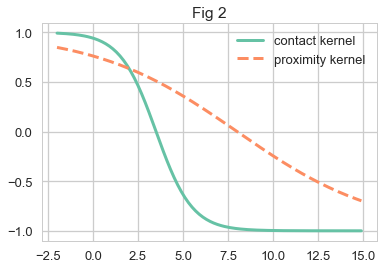

In [4]:
fig, ax = plt.subplots(1)
ax.set_title('Fig 2')
ax.plot(x, y_1, linewidth=3., linestyle='-', label ='contact kernel') 
ax.plot(x, y_2, linewidth=3., linestyle='--', label='proximity kernel')
ax.legend(markerscale=3)
plt.show()

<div name="fig2" align="center"> **Fig 2** Example of the kernel functions employed </div>

## Proof of concept

We'll apply this method in Pru P 3 + ligand in an unbiased simulation.

### Preprocessing

In [5]:
import prody as pdy

In [6]:
psf_A=pdy.parsePSF('F:DM/run1/prup3_lig_A/prup3_lig_A_charmm.psf')
dcd_A=pdy.DCDFile('F:DM/run1/prup3_lig_A/prup3_lig_A_nwater_pbcsolved.dcd')
psf_B=pdy.parsePSF('F:DM/run1/prup3_lig_B/prup3_lig_B_charmm.psf')
dcd_B=pdy.DCDFile('F:DM/run1/prup3_lig_B/prup3_lig_B_nwater_pbcsolved.dcd')
dcd_A.link(psf_A)
dcd_B.link(psf_B)

### Declaring anlysis functions

In [7]:
def kernel(res, seg, alpha=1., r0=3.5):
    assert isinstance(res, np.ndarray)
    assert isinstance(seg, np.ndarray)
    R = res.shape[0]
    S = seg.shape[0]
    kernel = 0.0
    
    D = np.zeros((R,S), dtype='float64')
    for k in range(R):
        D[k,:] = np.linalg.norm(seg - res[k,:], axis = 1)
    kernel = np.sum((2/((1+np.exp(D- r0)))) - 1) /(R*S)
    return kernel
contact_kernel = lambda x, s: kernel(x,s,alpha=1., r0=3.5)
proximity_kernel = lambda x, s: kernel(x,s,alpha=0.25, r0=8.0)

In [8]:
psf_hv = psf_A.getHierView()
num_residues_A = psf_hv.numResidues()
num_frames_A = dcd_A.numFrames()
num_segments = 3

psf_hv = psf_B.getHierView()
num_residues_B = psf_hv.numResidues()
num_frames_B = dcd_B.numFrames()

In [9]:
sel_lig = pdy.parsePDB('selection_lig.pdb')
seq_mask = dict(
    campto = sel_lig.getBetas() == 3.0,
    bridge = sel_lig.getBetas() == 2.0,
    tail = sel_lig.getBetas() == 1.0
)


@> 104 atoms and 1 coordinate set(s) were parsed in 0.00s.


In [10]:
contact_map_A = np.zeros((num_residues_A -1, num_frames_A, num_segments), dtype='float64')
contact_map_B = np.zeros((num_residues_B -1, num_frames_B, num_segments), dtype='float64')

### Obtaining contact tensors on natural ligand (orientations A and B)

In [11]:
for i, fr in enumerate(dcd_A):
    hv = fr.getAtoms().getHierView()
    lig = hv.getResidue(resnum=101, chid='', segname='HETA')
    head = lig.getCoords()[seq_mask['campto'],:]
    bridge = lig.getCoords()[seq_mask['bridge'],:]
    tail = lig.getCoords()[seq_mask['tail'],:]
    for res_id in range(1, num_residues_A):
        res = hv.getResidue(resnum=res_id, chid='', segname='PROA').getCoords()
        contact_map_A[res_id-1, i, 0] = contact_kernel(res, head)
        contact_map_A[res_id-1, i, 1] = contact_kernel(res, bridge)
        contact_map_A[res_id-1, i, 2] = contact_kernel(res, tail)
    print(".", end = '')
    if (i % 10 == 0) and i > 0:
        print(" ".format(i), end = "")
    if (i % 100 == 0) and i > 0:
        print(" %4d" % i)

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


........... .......... .......... .......... .......... .......... .......... .......... .......... ..........   100
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   200
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   300
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   400
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   500
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   600
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   700
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   800
.......... .......... .......... .......... .......... .......... .....

In [12]:
for i, fr in enumerate(dcd_B):
    hv = fr.getAtoms().getHierView()
    lig = hv.getResidue(resnum=101, chid='', segname='HETA')
    head = lig.getCoords()[seq_mask['campto'],:]
    bridge = lig.getCoords()[seq_mask['bridge'],:]
    tail = lig.getCoords()[seq_mask['tail'],:]
    for res_id in range(1, num_residues_B):
        res = hv.getResidue(resnum=res_id, chid='', segname='PROA').getCoords()
        contact_map_B[res_id-1, i, 0] = contact_kernel(res, head)
        contact_map_B[res_id-1, i, 1] = contact_kernel(res, bridge)
        contact_map_B[res_id-1, i, 2] = contact_kernel(res, tail)
    print(".", end = '')
    if (i % 10 == 0) and i > 0:
        print(" ".format(i), end = "")
    if (i % 100 == 0) and i > 0:
        print(" %4d" % i)

.

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   100
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   200
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   300
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   400
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   500
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   600
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   700
.......... .......... .......... .......... .......... .......... .......... .......... .......... ..........   800
.......... .......... .......... .......... .......... .......... ......

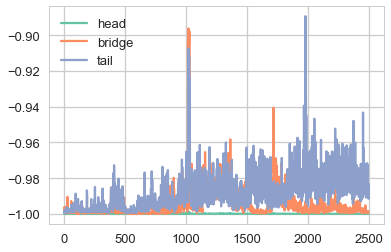

In [13]:
plt.plot(contact_map_B[79,:,0], label = 'head')
plt.plot(contact_map_B[79,:,1], label = 'bridge')
plt.plot(contact_map_B[79,:,2], label = 'tail')
plt.legend()
plt.show()

In [14]:
reshaped_contact_map_A = contact_map_A.reshape(91, -1)
A = reshaped_contact_map_A[:,:].dot(reshaped_contact_map_A[:,:].T)/ num_residues_A

reshaped_contact_map_B = contact_map_B.reshape(91, -1)
B = reshaped_contact_map_B[:,:].dot(reshaped_contact_map_B[:,:].T)/ num_residues_B

### Clustering analysis

Using hierarchical clustering

In [15]:
from sklearn.cluster import AgglomerativeClustering
aggc_A = AgglomerativeClustering(n_clusters=4)
aggc_B = AgglomerativeClustering(n_clusters=4)
aggc_A.fit(A)
aggc_B.fit(B)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=4,
            pooling_func=<function mean at 0x000001D8EF873D08>)

## Results

### Visualization of the cluster structure of the covariance matrix

We'll begin by using cluster maps to represent the possible interaction modes within the covariance matrix. 

** Fig 3 A ** Covariance matrix of the contact map with the ligand in orientation A

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


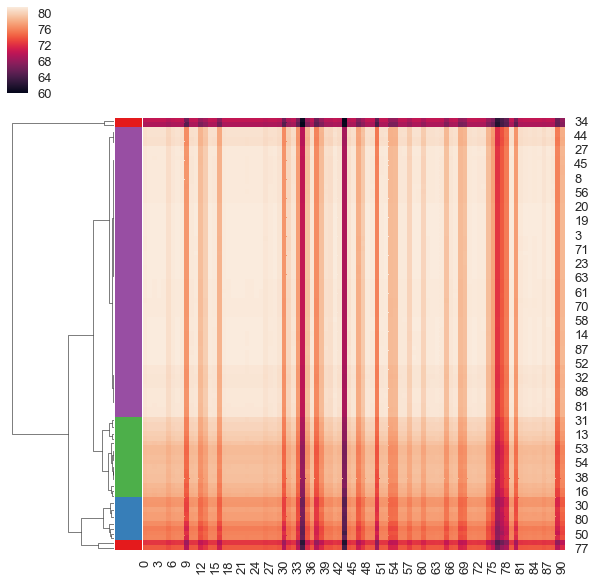

In [27]:
color_map = sns.color_palette('Set1', n_colors=4)
sns.clustermap(A, col_cluster=False, row_colors=[color_map[i] for i in aggc_A.labels_], )
plt.tight_layout()
plt.savefig('figure3A.png', dpi = 300)
plt.show()

** Fig 3 B ** Covariance matrix of the contact map with the ligand in orientation B

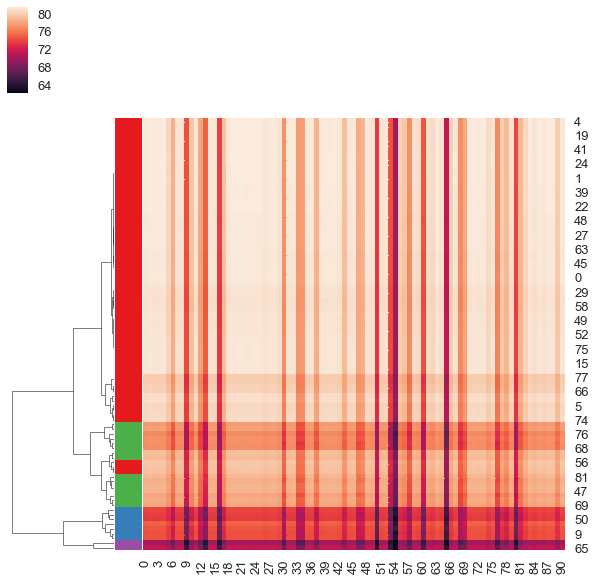

In [28]:
color_map = sns.color_palette('Set1', n_colors=4)
sns.clustermap(B, col_cluster=False, row_colors=[color_map[i] for i in aggc_B.labels_], )
plt.savefig('figure3B.png', dpi = 300)
plt.show()

### Depiction in the structure

We'll represent each of the modes in the structure so we can understand the resulting groups better.

In [18]:
prup3_ligA = pdy.parsePDB('prup3_lig_A_2450.pdb')
prup3_ligB = pdy.parsePDB('prup3_lig_B_2450.pdb')

@> 1380 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 1380 atoms and 1 coordinate set(s) were parsed in 0.01s.


In [19]:
ocupancies_A = np.zeros(prup3_ligA.numAtoms())
ocupancies_B = np.zeros(prup3_ligB.numAtoms())
for i, atom in enumerate(prup3_ligA.select('protein')): 
    n = atom.getResnum()
    try :
        ocupancies_A[i] = aggc_A.labels_[n -1]
    except IndexError:
        pass
for i, atom in enumerate(prup3_ligB.select('protein')): 
    n = atom.getResnum()
    try :
        ocupancies_B[i] = aggc_B.labels_[n -1]
    except IndexError:
        pass

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):


In [20]:
prup3_ligA.setOccupancies(ocupancies_A)
pdy.writePDB(filename='clustering_results_A.pdb', atoms=prup3_ligA)
prup3_ligB.setOccupancies(ocupancies_B)
pdy.writePDB(filename='clustering_results_B.pdb', atoms=prup3_ligB)

'clustering_results_B.pdb'

** Fig 5 A **

Depiction of clusters in the frame 2450 of pru p 3 + lig A (MD)
<img id="fig5" src="fig_5A.png" width=600px>


** Fig 5 B **
Depiction of clusters in the frame 2450 of Pru P 3 + lig B (MD)

Important note: colours red and purple are changed to avoid visual overwhelm
<img id="fig1" src="fig_5B.png" width=600px>

### Representing interaction time series

To better understand which are the parts with which each residue interacts, we'll represent the contact maps along time for each residue. We'll begin by plotting the ligand A and then B

** Fig 6 A ** Head contact map ligand A

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


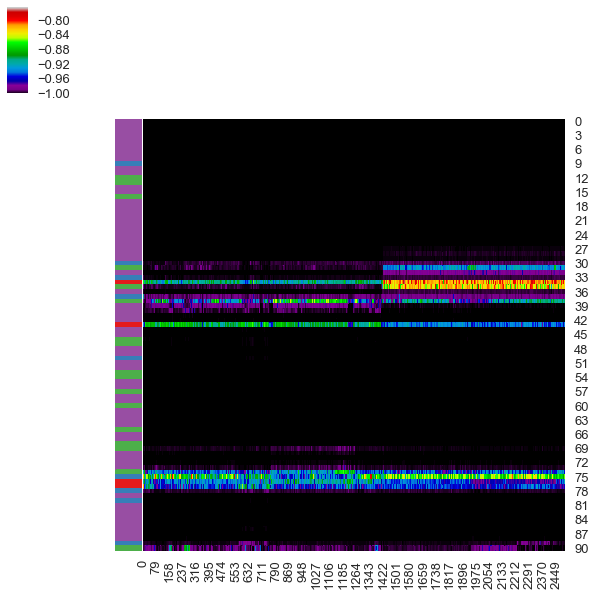

In [21]:
cm = sns.clustermap(
    contact_map_A[:,:,0], 
    row_colors=[color_map[i] for i in aggc_A.labels_], col_cluster=False, cmap='spectral',
    row_cluster=False
)

plt.show()

** Fig 6 B ** Bridge contact map with ligand A

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


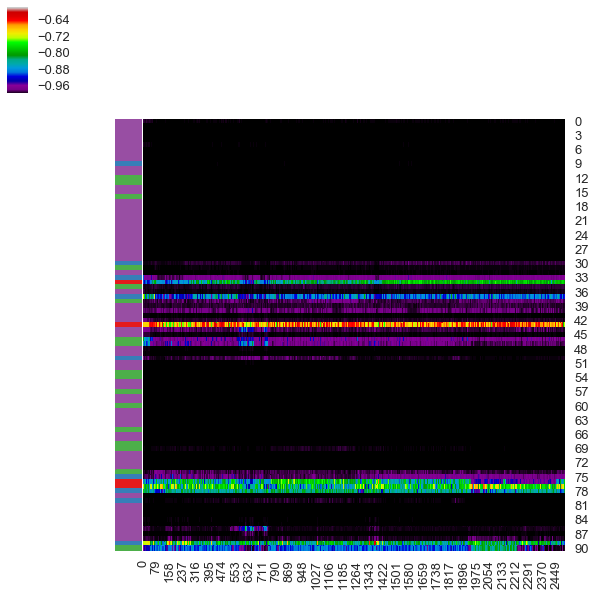

In [22]:
sns.clustermap(
    contact_map_A[:,:,1], 
    row_colors=[color_map[i] for i in aggc_A.labels_], col_cluster=False, cmap='spectral',
    row_cluster=False
)
plt.show()

** Fig 6C ** Tail contact map with ligand A

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


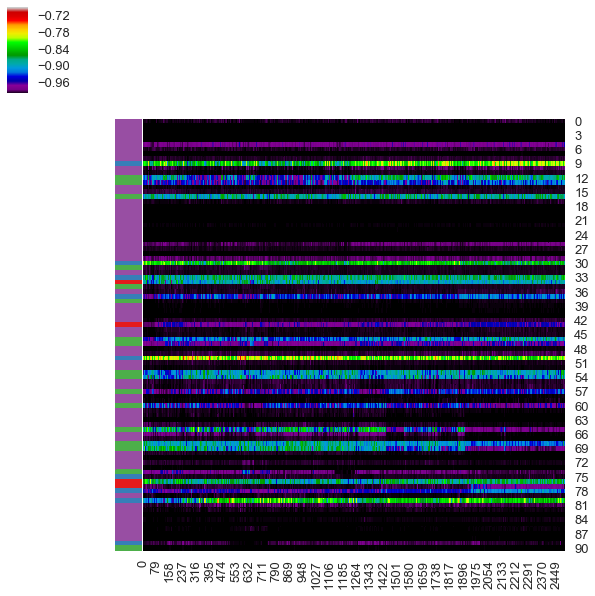

In [23]:
sns.clustermap(
    contact_map_A[:,:,2], 
    row_colors=[color_map[i] for i in aggc_A.labels_], col_cluster=False, cmap='spectral',
    row_cluster=False
)
plt.show()

** Fig 7 A** Head contact map with ligand B


C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


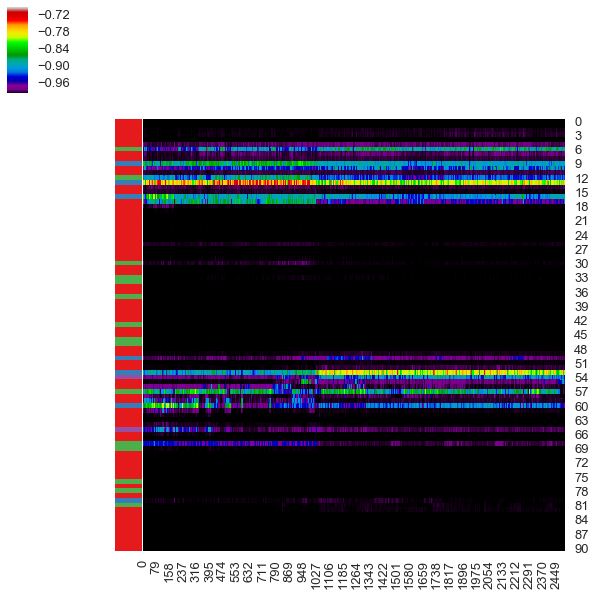

In [24]:
sns.clustermap(
    contact_map_B[:,:,0], 
    row_colors=[color_map[i] for i in aggc_B.labels_], col_cluster=False, cmap='spectral',
    row_cluster=False
)
plt.show()

** Fig 7 B** Bridge contact map with ligand B

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


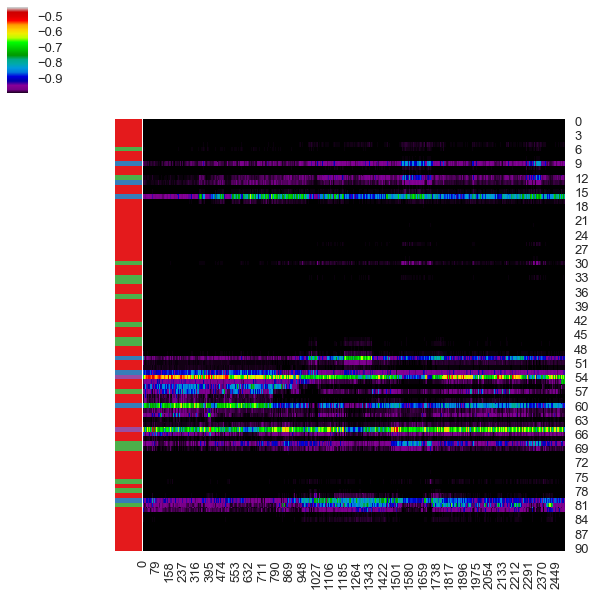

In [25]:
sns.clustermap(
    contact_map_B[:,:,1], 
    row_colors=[color_map[i] for i in aggc_B.labels_], col_cluster=False, cmap='spectral',
    row_cluster=False
)
plt.show()

** Fig 7 C** Tail contact map with ligand B

C:\Users\Bruno\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


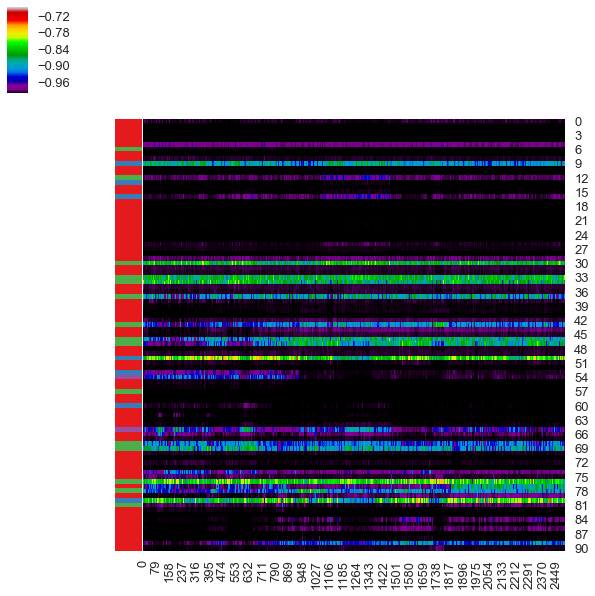

In [26]:
sns.clustermap(
    contact_map_B[:,:,2], 
    row_colors=[color_map[i] for i in aggc_B.labels_], col_cluster=False, cmap='spectral',
    row_cluster=False
)
plt.show()

## Conclussions

- We can observe in Fig3 A and B that there are a few well defined clusters of interaction modes with the different parts of the ligand that we have defined.
- The depiction shows that the most reduced clusters (in red) are formed by residues that interact tightly with the ligand. This is specially interesting in the orientation A, where four residues (N35, R44, P78, I77) form some sort of ring around the bridge. It can be observed in Fig 6 B how the interaction of this residues is specially strong.
- In the orientation B, there are not so clear residues forming a ring in the opening of the cavity. We've depicted a set of residues from the two clusters with larger covariances (purple and blue), since they show the tightest interactions with the brdige and head (fig 7B and 7C).
- The clusters green and blue of orientation A seem to represent alternative binding modes with the tail, as it can be observed in fig 6C.
- The green cluster of the orientation B is a mode of interaction with the tail.
- The red cluster of orientation B and the purple cluster of orientation A represent the group of residues that do not interact with any of the parts of the ligand.